<a href="https://colab.research.google.com/github/AdityaVijayvergia/Machine-Learning-Projects/blob/master/gan_for_quadratic_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

In [2]:
(np.random.random_sample((20))-0.5)*10

array([ 2.8866457 ,  2.10442355,  0.93047409,  1.87146582,  2.22452613,
        0.1355059 , -4.85037623,  0.37567338,  2.08961822,  3.75676744,
       -1.38202966, -4.72696677, -3.23968139, -0.80629677, -2.21912158,
       -3.44187154,  0.37354729, -4.03869863,  3.03166782,  1.67791332])

In [0]:
def fun(x):
    return x**2 + 2;

def gen_data(n=1000,scale=100):
    x=(np.random.random_sample((n))-0.5)*scale
    y=np.array([fun(xi) for xi in x])
    x = x.astype('float32')
    y = y.astype('float32')
    data = np.vstack([x,y]).T
    return data, x, y

def gen_noise(m, n=2):
    return np.random.uniform(-1., 1., size=[m, n])

In [4]:
data,_,_ = gen_data()
data.shape

(1000, 2)

In [5]:
gen_noise().shape

(1000, 2)

In [6]:
_, x_train, y_train = gen_data()
print(x_train.shape)
print(y_train.shape)

(1000,)
(1000,)


In [0]:
import matplotlib.pylab as plt

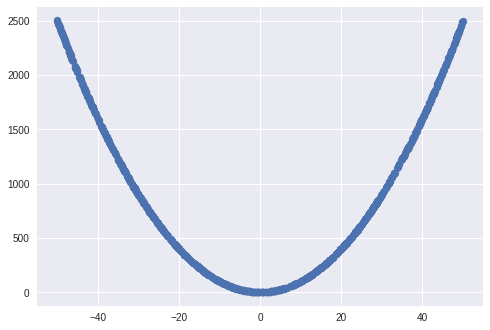

In [8]:
plt.scatter(x_train,y_train)

In [0]:
import tensorflow as tf 

In [0]:
def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

In [0]:
def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

In [12]:
data, _, _ = gen_data()
data

array([[  19.999813,  401.9925  ],
       [ -35.04758 , 1230.3329  ],
       [ -37.434456, 1403.3385  ],
       ...,
       [ -27.58779 ,  763.0861  ],
       [   6.503547,   44.296127],
       [  46.014744, 2119.3567  ]], dtype=float32)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
sess.run(tf.ones_like([[1,2,3],[4,5,6]]))

array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)

In [0]:
real_data = tf.placeholder(tf.float32, [None, 2])
random_noise = tf.placeholder(tf.float32, [None, 2])

In [16]:
generated_data = generator(random_noise)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [0]:
real_out, real_val = discriminator(real_data)
fake_out, fake_val = discriminator(generated_data,reuse=True)

In [18]:
data.shape

(1000, 2)

In [0]:
d_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = real_out, labels = tf.ones_like(real_out)) + 
    tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_out, labels = tf.zeros_like(fake_out))
)

In [0]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = fake_out, labels = tf.ones_like(fake_out)))

In [0]:
gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='GAN/Generator')
dis_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='GAN/Discriminator')

In [0]:
gen_train_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(g_loss, var_list=gen_vars)
dis_train_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(d_loss, var_list=dis_vars)

In [0]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

In [48]:
x_plot,_,_ = gen_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

44

In [0]:
for i in range(10000):
    real_data_batch,_,_ = gen_data(n=batch_size)
    random_noise_batch = gen_noise(batch_size)
    
    for _ in range(nd_steps):
        _, dloss = sess.run([dis_train_step, d_loss], feed_dict={real_data:real_data_batch, random_noise:random_noise_batch})

    rrep_dstep, grep_dstep = sess.run([real_val, fake_val], feed_dict={real_data:real_data_batch, random_noise:random_noise_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_train_step, g_loss], feed_dict={random_noise:random_noise_batch})

    rrep_gstep, grep_gstep = sess.run([real_val, fake_val], feed_dict={real_data:real_data_batch, random_noise:random_noise_batch})
    
    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(generated_data, feed_dict={random_noise:random_noise_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        #plt.savefig('../plots/iterations/iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        #plt.savefig('../plots/features/feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        #plt.savefig('../plots/features/feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()
        

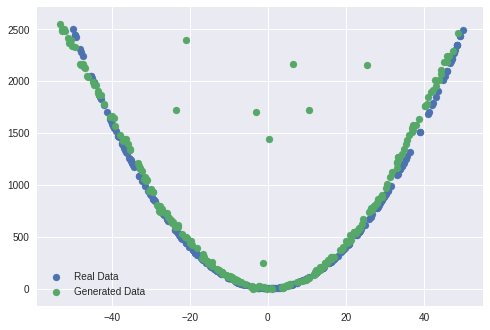

In [70]:
random_noise_batch = gen_noise(batch_size)
plt.figure()
g_plot = sess.run(generated_data, feed_dict={random_noise:random_noise_batch})
xax = plt.scatter(x_plot[:,0], x_plot[:,1])
gax = plt.scatter(g_plot[:,0],g_plot[:,1])
plt.legend((xax,gax), ("Real Data","Generated Data"))

In [73]:
gen_vars

[<tf.Variable 'GAN/Generator/dense/kernel:0' shape=(2, 16) dtype=float32_ref>,
 <tf.Variable 'GAN/Generator/dense/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'GAN/Generator/dense_1/kernel:0' shape=(16, 16) dtype=float32_ref>,
 <tf.Variable 'GAN/Generator/dense_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'GAN/Generator/dense_2/kernel:0' shape=(16, 2) dtype=float32_ref>,
 <tf.Variable 'GAN/Generator/dense_2/bias:0' shape=(2,) dtype=float32_ref>]